#**유통 판매량 예측 및 재고 최적화**
## **단계2 : 모델링을 위한 데이터 전처리**

# **0.미션**

* 단계1 상품별 데이터셋 만들기
    * 가설로 도출된 변수를 반영한 데이터셋을 상품별로 생성
* 단계2 기초 모델 생성
    * base line model : dense layer만 이용해서 기초 모델 생성
    * LSTM, CNN 알고리즘을 이용해서 기초 모델 생성

* 대상 상품(핵심 상품)

| Product_ID|Product_Code|SubCategory|Category|LeadTime|Price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Drink|2|8|
|12|GA001|Milk|Food|3|6|
|42|FM001|Agricultural products|Grocery|3|5|


# **1.환경설정**

* 세부 요구사항
    * 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 라이브러리 로딩
        * 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### **(1) 경로 설정**

* 구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/KT미프/6차/'

### **(2) 라이브러리 설치 및 불러오기**

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

from keras.models import Sequential
from keras.backend import clear_session
from keras.layers import Dense, LSTM, Conv1D, Flatten, Input, SimpleRNN
from keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

In [4]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [5]:
# 예측 결과 시각화
def plot_model_result(y_train, y_val, pred) :

    y_train = pd.Series(y_train)
    y_val = pd.Series(y_val)
    y_val.index = range(len(y_train), len(y_train) + len(y_val))

    pred = pd.Series(pred.reshape(-1,), index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

### **(3) 데이터 불러오기**

In [6]:
oil_price = pd.read_csv(path + 'train/oil_price_train.csv')
orders = pd.read_csv(path + 'train/orders_train.csv')
sales = pd.read_csv(path + 'train/sales_train.csv')
products = pd.read_csv(path + 'train/products.csv')
stores = pd.read_csv(path + 'train/stores.csv')

sales['Date'] = pd.to_datetime(sales['Date'] )
oil_price['Date'] = pd.to_datetime(oil_price['Date'] )
orders['Date'] = pd.to_datetime(orders['Date'] )

# **2.데이터셋 구성하기**

* 세부 요구사항
    * 상품코드 별로 각각 데이터셋을 구성해야 합니다.
    * 도출된 변수들을 포함하는 데이터셋을 구성합니다.


## **(1) 상품 : 3 - Beverage**

In [44]:
df = sales.loc[(sales['Store_ID'] == 44) & (sales['Product_ID'] ==3)]

print(len(df))

1152


In [45]:
new_data = pd.DataFrame({
    'Date': pd.to_datetime(['2014-12-25', '2015-12-25', '2016-12-25']),
    'Store_ID': [44, 44, 44],
    'Qty': [np.nan, np.nan, np.nan],
    'Product_ID': [3, 3, 3]
}, index=[1000001, 1000002, 1000003])

df = pd.concat([df, new_data])
df = df.sort_values(by='Date', ascending=True)
print(len(df))
df.tail()

1155


,Date,Store_ID,Qty,Product_ID
930865,2017-02-24,44,10208.0,3
931676,2017-02-25,44,12361.0,3
932487,2017-02-26,44,10108.0,3
933298,2017-02-27,44,10006.0,3
934109,2017-02-28,44,14374.0,3


In [46]:
order_44 = orders.loc[orders['Store_ID'] ==44]
data = pd.merge(df, order_44, on='Date', how ='left')
data.drop(columns = 'Store_ID_y', inplace = True)
print(data.shape)
data.head()

(1155, 5)


,Date,Store_ID_x,Qty,Product_ID,CustomerCount
0,2014-01-01,44,0.0,3,NaN
1,2014-01-02,44,9853.0,3,4422.0
2,2014-01-03,44,8647.0,3,4167.0
3,2014-01-04,44,15153.0,3,5341.0
4,2014-01-05,44,15606.0,3,5123.0


## **(2) 상품 : 12 - Milk**

In [74]:
# 44번 매장의 12번 물품 데이터 필터링
filtered_sales = sales[(sales['Store_ID'] == 44) & (sales['Product_ID'] == 12)]

# 8번 물품(요거트)의 판매량을 별도로 추출하여 병합
yogurt_sales = sales[(sales['Store_ID'] == 44) & (sales['Product_ID'] == 8)]
yogurt_sales = yogurt_sales[['Date', 'Qty']].rename(columns={'Qty': 'Yogurt_Qty'})
filtered_sales = filtered_sales.merge(yogurt_sales, on='Date', how='left')

# 날짜 요소 추가 (주말 여부 및 연말 시즌 여부)
filtered_sales['day_of_week'] = filtered_sales['Date'].dt.dayofweek  # 0: 월요일, 6: 일요일
filtered_sales['is_weekend'] = filtered_sales['day_of_week'] >= 5     # 주말 여부 (토, 일)
filtered_sales['is_year_end'] = filtered_sales['Date'].dt.month.isin([12])  # 연말 시즌 여부

# 다른 테이블과 데이터 병합
# 날짜 기준으로 oil_price와 병합
merged_data = filtered_sales.merge(oil_price, on='Date', how='left')
# 주문 테이블과 Store_ID로 병합
merged_data = merged_data.merge(orders, on=['Date', 'Store_ID'], how='left')

# 결측치 선형 보간법 처리
merged_data.interpolate(method='linear', inplace=True)

# 리드타임(2일) 반영하여 타겟 생성
merged_data['Target'] = merged_data['Qty'].shift(-2)
merged_data.dropna(inplace=True)  # 타겟 없는 마지막 2일 제거

# 최종 데이터셋 확인
print(merged_data.head())

        Date  Store_ID      Qty  Product_ID  Yogurt_Qty  day_of_week  \
1 2014-01-02        44   9647.0          12      2991.0            3   
2 2014-01-03        44   8879.0          12      2694.0            4   
3 2014-01-04        44  14188.0          12      4355.0            5   
4 2014-01-05        44  14490.0          12      4228.0            6   
5 2014-01-06        44   7614.0          12      2323.0            0   

   is_weekend  is_year_end  WTI_Price  CustomerCount   Target  
1       False        False      95.14         4422.0  14188.0  
2       False        False      93.66         4167.0  14490.0  
3        True        False      93.48         5341.0   7614.0  
4        True        False      93.30         5123.0   7124.0  
5       False        False      93.12         3917.0   8683.0  


In [75]:
# 피쳐와 타겟 분리
X = merged_data.drop(columns=['Target', 'Date', 'Store_ID', 'Product_ID'])
y = merged_data['Target']

In [76]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

# 수치형 컬럼 및 범주형 컬럼 구분
numeric_columns = ['Qty', 'Yogurt_Qty', 'WTI_Price', 'CustomerCount']
categorical_columns = ['day_of_week']

# 1. 수치형 데이터 스케일링 (MinMaxScaler)
scaler = MinMaxScaler()
X_numeric_scaled = scaler.fit_transform(X[numeric_columns])
X_numeric_scaled = pd.DataFrame(X_numeric_scaled, columns=numeric_columns)

# 2. 범주형 데이터 인코딩 (One-Hot Encoding for day_of_week)
encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop='first'로 첫 번째 열을 제거하여 다중공선성 방지
X_categorical_encoded = encoder.fit_transform(X[categorical_columns])
X_categorical_encoded = pd.DataFrame(X_categorical_encoded, columns=encoder.get_feature_names_out(categorical_columns))

# 3. 이진 컬럼 (is_weekend, is_year_end) 추가
X_binary = X[['is_weekend', 'is_year_end']].reset_index(drop=True)

# 4. 스케일링, 인코딩된 데이터 통합
X_processed = pd.concat([X_numeric_scaled, X_categorical_encoded, X_binary], axis=1)

# 결과 확인
print(X_processed.head())

        Qty  Yogurt_Qty  WTI_Price  CustomerCount  day_of_week_1  \
0  0.259985    0.557606   0.843322       0.326893            0.0   
1  0.239287    0.502237   0.825220       0.283296            0.0   
2  0.382364    0.811894   0.823019       0.484014            0.0   
3  0.390503    0.788218   0.820817       0.446743            0.0   
4  0.205196    0.433072   0.818615       0.240554            0.0   

   day_of_week_2  day_of_week_3  day_of_week_4  day_of_week_5  day_of_week_6  \
0            0.0            1.0            0.0            0.0            0.0   
1            0.0            0.0            1.0            0.0            0.0   
2            0.0            0.0            0.0            1.0            0.0   
3            0.0            0.0            0.0            0.0            1.0   
4            0.0            0.0            0.0            0.0            0.0   

   is_weekend  is_year_end  
0       False        False  
1       False        False  
2        True        Fa

In [77]:
# y 스케일링
y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1))

## **(3) 상품 : 42 - Agricultural products**

In [7]:
# 44번 매장의 42번 상품
# 이틀 뒤 Qty값 타겟팅

sales_44_42 = sales.loc[(sales['Product_ID'] == 42)&(sales['Store_ID'] == 44)]
sales_44_42['y'] = sales_44_42['Qty'].shift(-2)
sales_44_42 = sales_44_42[:-2]
sales_44_42.tail()

,Date,Store_ID,Qty,Product_ID,y
929256,2017-02-22,44,72.0,42,91.0
930067,2017-02-23,44,98.0,42,105.0
930878,2017-02-24,44,91.0,42,108.0
931689,2017-02-25,44,105.0,42,78.0
932500,2017-02-26,44,108.0,42,87.0


In [8]:
# 유가 병합

sales_44_42 = pd.merge(sales_44_42, oil_price, on = 'Date', how = 'left')
sales_44_42.head()

,Date,Store_ID,Qty,Product_ID,y,WTI_Price
0,2014-01-01,44,51.0,42,74.0,NaN
1,2014-01-02,44,76.0,42,78.0,95.14
2,2014-01-03,44,74.0,42,88.0,93.66
3,2014-01-04,44,78.0,42,65.0,NaN
4,2014-01-05,44,88.0,42,78.0,NaN


In [9]:
# 방문 고객 수 병합

sales_44_42 = pd.merge(sales_44_42, orders, on = ['Date', 'Store_ID'], how = 'left')
sales_44_42.head()

,Date,Store_ID,Qty,Product_ID,y,WTI_Price,CustomerCount
0,2014-01-01,44,51.0,42,74.0,NaN,NaN
1,2014-01-02,44,76.0,42,78.0,95.14,4422.0
2,2014-01-03,44,74.0,42,88.0,93.66,4167.0
3,2014-01-04,44,78.0,42,65.0,NaN,5341.0
4,2014-01-05,44,88.0,42,78.0,NaN,5123.0


In [10]:
# 요일 컬럼 추가
sales_44_42['Weekday'] = sales_44_42['Date'].dt.weekday
sales_44_42.head()

,Date,Store_ID,Qty,Product_ID,y,WTI_Price,CustomerCount,Weekday
0,2014-01-01,44,51.0,42,74.0,NaN,NaN,2
1,2014-01-02,44,76.0,42,78.0,95.14,4422.0,3
2,2014-01-03,44,74.0,42,88.0,93.66,4167.0,4
3,2014-01-04,44,78.0,42,65.0,NaN,5341.0,5
4,2014-01-05,44,88.0,42,78.0,NaN,5123.0,6


In [11]:
# 같은 카테고리 물품들의 당일 판매량 추가
category_Grocery_PD = list(products.loc[products['Category']=='Grocery']['Product_ID'])
category_Grocery_PD.remove(42)
print(category_Grocery_PD)

sales_44 = sales_44_42.copy()
for pid in category_Grocery_PD:
  sales_44_Grocery = sales.loc[(sales['Product_ID']==pid)&(sales['Store_ID']==44),['Date','Qty']]
  sales_44_Grocery['Qty'] = sales_44_Grocery['Qty'].replace(0, pd.NA) # 0값 결측치로 처리
  sales_44_Grocery.columns = ['Date', 'Qty_'+str(pid)]
  sales_44 = pd.merge(sales_44, sales_44_Grocery, on = 'Date', how = 'left')

sales_44.head()

[32, 10, 24]


,Date,Store_ID,Qty,Product_ID,y,WTI_Price,CustomerCount,Weekday,Qty_32,Qty_10,Qty_24
0,2014-01-01,44,51.0,42,74.0,NaN,NaN,2,<NA>,<NA>,<NA>
1,2014-01-02,44,76.0,42,78.0,95.14,4422.0,3,124.978,780.0,981.644
2,2014-01-03,44,74.0,42,88.0,93.66,4167.0,4,115.0889,677.0,1278.9081
3,2014-01-04,44,78.0,42,65.0,NaN,5341.0,5,171.164,1126.0,1398.666
4,2014-01-05,44,88.0,42,78.0,NaN,5123.0,6,217.252,1118.0,1119.535


In [12]:
sales_44.isna().sum()

,0
Date,0
Store_ID,0
Qty,0
Product_ID,0
y,0
WTI_Price,360
CustomerCount,9
Weekday,0
Qty_32,7
Qty_10,7


In [13]:
# 결측치는 전날/다음날 값으로 처리

sales_44 = sales_44.fillna(method = 'ffill')
sales_44 = sales_44.fillna(method = 'bfill')
sales_44.head()

,Date,Store_ID,Qty,Product_ID,y,WTI_Price,CustomerCount,Weekday,Qty_32,Qty_10,Qty_24
0,2014-01-01,44,51.0,42,74.0,95.14,4422.0,2,124.9780,780.0,981.6440
1,2014-01-02,44,76.0,42,78.0,95.14,4422.0,3,124.9780,780.0,981.6440
2,2014-01-03,44,74.0,42,88.0,93.66,4167.0,4,115.0889,677.0,1278.9081
3,2014-01-04,44,78.0,42,65.0,93.66,5341.0,5,171.1640,1126.0,1398.6660
4,2014-01-05,44,88.0,42,78.0,93.66,5123.0,6,217.2520,1118.0,1119.5350


In [ ]:
products.head(3)

,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price
0,20,HG001,Gardening Tools,Household Goods,2,50
1,27,HH001,Home Appliances,Household Goods,2,150
2,16,HK001,Kitchen,Household Goods,2,23


In [ ]:
orders.head(3)

,Date,Store_ID,CustomerCount
0,2014-01-01,25,840
1,2014-01-01,36,487
2,2014-01-02,1,1875


In [ ]:
stores.head(3)


,Store_ID,City,State,Store_Type
0,1,Saint Paul,\tMinnesota,4
1,2,Saint Paul,\tMinnesota,4
2,3,Saint Paul,\tMinnesota,4


In [ ]:
oil_price.head(3)

,Date,WTI_Price
0,2014-01-01,NaN
1,2014-01-02,95.14
2,2014-01-03,93.66


# **3.Baseline Model**

* **세부 요구사항**
    * 데이터 준비
        * 스케일링
            * 교과서 적으로는 데이터 분할 이후 스케일링하는게 맞지만, 데이터 건수가 충분히 크다면, 스케일링을 먼저 하기도 합니다.
            * 여기서는 먼저 스케일링을 한 후 데이터 분할을 합니다.
        * 데이터 분할
            * 검증셋 구성 : 학습용 데이터에서 최근 60일을 검증셋으로 사용.

    * 모델링
        * Dense Layer 1개(output layer)만으로 모델을 생성합니다.
        * 모델의 검증 성능을 평가하고 기록합니다.
        * 평가 지표 : RMSE, MAE, MAPE, R2 Score


## **(1) 상품 : 3 - Beverage**

### **1) 데이터 준비**

In [47]:
data['year'] = data['Date'].dt.year
data['month'] = data['Date'].dt.month
data['day'] = data['Date'].dt.day
data['day_name'] = data['Date'].dt.day_name()
data.head()

,Date,Store_ID_x,Qty,Product_ID,CustomerCount,year,month,day,day_name
0,2014-01-01,44,0.0,3,NaN,2014,1,1,Wednesday
1,2014-01-02,44,9853.0,3,4422.0,2014,1,2,Thursday
2,2014-01-03,44,8647.0,3,4167.0,2014,1,3,Friday
3,2014-01-04,44,15153.0,3,5341.0,2014,1,4,Saturday
4,2014-01-05,44,15606.0,3,5123.0,2014,1,5,Sunday


In [48]:
 data = pd.merge(data,oil_price, on = 'Date', how ='left')
 data = data.set_index('Date')
 data

,Store_ID_x,Qty,Product_ID,CustomerCount,year,month,day,day_name,WTI_Price
Date,,,,,,,,,
2014-01-01,44,0.0,3,NaN,2014,1,1,Wednesday,NaN
2014-01-02,44,9853.0,3,4422.0,2014,1,2,Thursday,95.14
2014-01-03,44,8647.0,3,4167.0,2014,1,3,Friday,93.66
2014-01-04,44,15153.0,3,5341.0,2014,1,4,Saturday,NaN
2014-01-05,44,15606.0,3,5123.0,2014,1,5,Sunday,NaN
...,...,...,...,...,...,...,...,...,...
2017-02-24,44,10208.0,3,4549.0,2017,2,24,Friday,53.99
2017-02-25,44,12361.0,3,4619.0,2017,2,25,Saturday,NaN
2017-02-26,44,10108.0,3,3877.0,2017,2,26,Sunday,NaN


In [50]:
data['WTI_Price'] = data['WTI_Price'].interpolate(method='linear')
data['WTI_Price'] = data['WTI_Price'].fillna(method='bfill')

data['Qty'] = data['Qty'].fillna(0)

In [51]:
data[data.isnull().any(axis =1)]

,Store_ID_x,Qty,Product_ID,CustomerCount,year,month,day,day_name,WTI_Price
Date,,,,,,,,,
2014-01-01,44,0.0,3,NaN,2014,1,1,Wednesday,95.140
2014-12-25,44,0.0,3,NaN,2014,12,25,Thursday,55.145
2015-01-01,44,0.0,3,NaN,2015,1,1,Thursday,53.085
2015-12-25,44,0.0,3,NaN,2015,12,25,Friday,37.305
2016-01-01,44,0.0,3,NaN,2016,1,1,Friday,37.050
2016-01-03,44,18421.0,3,NaN,2016,1,3,Sunday,36.890
2016-01-04,44,11911.0,3,NaN,2016,1,4,Monday,36.810
2016-12-25,44,0.0,3,NaN,2016,12,25,Sunday,52.415
2017-01-01,44,0.0,3,NaN,2017,1,1,Sunday,53.055


In [52]:
data.loc[(data['month'] ==1) &(data['day'] ==1), 'CustomerCount'] = 0
data.loc[(data['month'] ==12) &(data['day'] ==25), 'CustomerCount'] = 0
data['CustomerCount'] = data['CustomerCount'].interpolate(method='linear')

In [53]:
data['Target'] = data['Qty'].shift(-2)
data['day_qty'] = data['Qty'].shift(1)
data['week_qty'] = data['Qty'].shift(7)
data['month_qty'] = data['Qty'].shift(30)
data

,Store_ID_x,Qty,Product_ID,CustomerCount,year,month,day,day_name,WTI_Price,Target,day_qty,week_qty,month_qty
Date,,,,,,,,,,,,,
2014-01-01,44,0.0,3,0.0,2014,1,1,Wednesday,95.140000,8647.0,NaN,NaN,NaN
2014-01-02,44,9853.0,3,4422.0,2014,1,2,Thursday,95.140000,15153.0,0.0,NaN,NaN
2014-01-03,44,8647.0,3,4167.0,2014,1,3,Friday,93.660000,15606.0,9853.0,NaN,NaN
2014-01-04,44,15153.0,3,5341.0,2014,1,4,Saturday,93.480000,7900.0,8647.0,NaN,NaN
2014-01-05,44,15606.0,3,5123.0,2014,1,5,Sunday,93.300000,7188.0,15153.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-24,44,10208.0,3,4549.0,2017,2,24,Friday,53.990000,10108.0,8018.0,9524.0,8465.0
2017-02-25,44,12361.0,3,4619.0,2017,2,25,Saturday,54.006667,10006.0,10208.0,16331.0,8016.0
2017-02-26,44,10108.0,3,3877.0,2017,2,26,Sunday,54.023333,14374.0,12361.0,12023.0,8709.0


In [54]:
data.dropna(inplace = True)

In [55]:
data = data.reset_index()
data.drop(columns=['Store_ID_x', 'Product_ID', 'Date', 'WTI_Price'], inplace = True)
data

,Qty,CustomerCount,year,month,day,day_name,Target,day_qty,week_qty,month_qty
0,7566.0,4189.0,2014,1,31,Friday,6995.0,5484.0,6552.0,0.0
1,7223.0,5130.0,2014,2,1,Saturday,4126.0,7566.0,11966.0,9853.0
2,6995.0,4827.0,2014,2,2,Sunday,3194.0,7223.0,12309.0,8647.0
3,4126.0,3989.0,2014,2,3,Monday,3633.0,6995.0,6821.0,15153.0
4,3194.0,3742.0,2014,2,4,Tuesday,3709.0,4126.0,5512.0,15606.0
...,...,...,...,...,...,...,...,...,...,...
1118,7856.0,3834.0,2017,2,22,Wednesday,10208.0,7177.0,7854.0,10157.0
1119,8018.0,3955.0,2017,2,23,Thursday,12361.0,7856.0,7829.0,8660.0
1120,10208.0,4549.0,2017,2,24,Friday,10108.0,8018.0,9524.0,8465.0
1121,12361.0,4619.0,2017,2,25,Saturday,10006.0,10208.0,16331.0,8016.0


In [56]:
data = pd.get_dummies(data, columns = ['day_name'], drop_first = True, dtype=int)

In [57]:
target = 'Target'
x = data.drop(target, axis = 1)
y = data.loc[:,target]

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x = scaler.fit_transform(x)
scaler_y = MinMaxScaler()
y = y.values.reshape(-1, 1)
y = scaler_y.fit_transform(y)

val_size = 60
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = val_size, shuffle = False)
x_train_reshaped = x_train.reshape(-1, 1, 14)
x_val_reshaped = x_val.reshape(-1, 1, 14)


### **2) 모델링**

In [60]:

model = Sequential([
    SimpleRNN(1, input_shape=(7, x_train_reshaped.shape[2])),
    Dense(1)
])
model.summary()
model.compile(loss='MeanSquaredError',
            optimizer='adam',
            metrics=['MeanAbsoluteError'])

history = model.fit(x_train_reshaped, y_train, validation_data =(x_val_reshaped, y_val), epochs=200, verbose=1).history


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 1)                   │              16 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               2 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18 (72.00 B)

 Trainable params: 18 (72.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - MeanAbsoluteError: 0.3423 - loss: 0.1630 - val_MeanAbsoluteError: 0.3573 - val_loss: 0.1806
Epoch 2/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - MeanAbsoluteError: 0.2976 - loss: 0.1259 - val_MeanAbsoluteError: 0.3321 - val_loss: 0.1536
Epoch 3/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - MeanAbsoluteError: 0.2743 - loss: 0.1060 - val_MeanAbsoluteError: 0.3066 - val_loss: 0.1299
Epoch 4/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - MeanAbsoluteError: 0.2495 - loss: 0.0890 - val_MeanAbsoluteError: 0.2796 - val_loss: 0.1080
Epoch 5/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - MeanAbsoluteError: 0.2189 - loss: 0.0705 - val_MeanAbsoluteError: 0.2628 - val_loss: 0.0953
Epoch 6/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - MeanAbsoluteError: 0.2011 - loss: 0.0608 - val_MeanAbsoluteError: 0.2450 - val_loss: 0.0828
Epoch 7/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - MeanAbsoluteError: 0.1918 - loss: 0.0533 - val_MeanAbsoluteError: 0.2271 - v

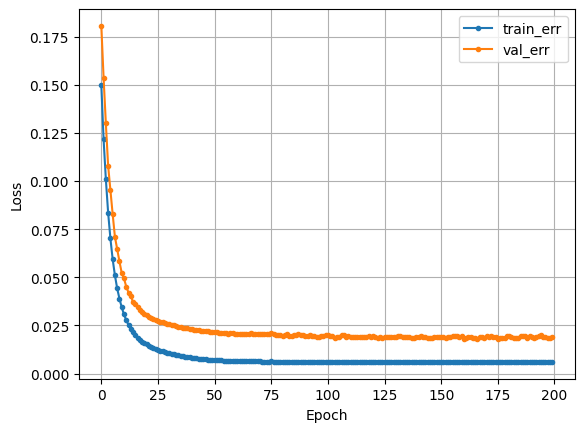

In [61]:
dl_history_plot(history)

In [62]:
from sklearn.metrics import *
y_pred = model.predict(x_val_reshaped)
# RMSE, MAE, MAPE, R2 Score
print(f'RMSE: {root_mean_squared_error(y_val, y_pred)}')
print(f'MAE: {mean_absolute_error(y_val, y_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(y_val, y_pred)}')
print(f'R2 Score: {r2_score(y_val, y_pred)}')

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
RMSE: 0.13826408735118048
MAE: 0.09251516059991514
MAPE: 43574103043823.086
R2 Score: 0.21675050341380386


## **(2) 상품 : 12 - Milk**

### **1) 데이터 준비**

In [78]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from math import sqrt

In [79]:
# 데이터 분할 (학습 및 검증 셋 구성)
train_size = len(X_processed) - 60
X_train, X_val = X_processed[:train_size], X_processed[train_size:]
y_train, y_val = y_scaled[:train_size], y_scaled[train_size:]


### **2) 모델링**

In [80]:
# Dense Layer 모델 구성
model = Sequential()
model.add(Dense(1, input_dim=X_train.shape[1]))  # 입력 차원은 X_train의 feature 수

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# 모델 학습
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_val, y_val), verbose=1)

Epoch 1/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3584 - val_loss: 0.2438
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1862 - val_loss: 0.1365
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1048 - val_loss: 0.0859
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0614 - val_loss: 0.0610
Epoch 5/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0444 - val_loss: 0.0460
Epoch 6/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0389 - val_loss: 0.0373
Epoch 7/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0268 - val_loss: 0.0319
Epoch 8/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0225 - val_loss: 0.0281
Epoch 9/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0176 - val_loss: 0.0257
Epoch 10/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0140 - val_loss: 0.0239
Epoch 11/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0132 - val_loss: 0.0226
Epoch 12/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0123 - val_lo

In [81]:
# 검증 성능 평가
# 예측
y_pred_scaled = model.predict(X_val)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [82]:
# 예측 값을 원래 스케일로 되돌리기
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_val_original = y_scaler.inverse_transform(y_val)

# 평가 지표 계산
rmse = sqrt(mean_squared_error(y_val_original, y_pred))
mae = mean_absolute_error(y_val_original, y_pred)
mape = np.mean(np.abs((y_val_original - y_pred.flatten()) / y_val_original)) * 100  # MAPE 계산
r2 = r2_score(y_val_original, y_pred)

# 결과 출력
print("RMSE:", rmse)
print("MAE:", mae)
print("MAPE:", mape)
print("R2 Score:", r2)

RMSE: 3930.7488066716733
MAE: 2439.716200764974
MAPE: inf
R2 Score: -0.2573047215026878


## **(3) 상품 : 42 - Agricultural products**

### **1) 데이터 준비**

In [14]:
sales_44.drop(columns = ['Date', 'Store_ID', 'Product_ID'], inplace = True)
sales_44.head()

,Qty,y,WTI_Price,CustomerCount,Weekday,Qty_32,Qty_10,Qty_24
0,51.0,74.0,95.14,4422.0,2,124.9780,780.0,981.6440
1,76.0,78.0,95.14,4422.0,3,124.9780,780.0,981.6440
2,74.0,88.0,93.66,4167.0,4,115.0889,677.0,1278.9081
3,78.0,65.0,93.66,5341.0,5,171.1640,1126.0,1398.6660
4,88.0,78.0,93.66,5123.0,6,217.2520,1118.0,1119.5350


In [15]:
# 타겟 컬럼 분리
x = sales_44.drop(columns = ['y'])
y = sales_44['y']

In [16]:
# 요일 가변수화
x = pd.get_dummies(x, columns = ['Weekday'], drop_first = True)
x.head()

,Qty,WTI_Price,CustomerCount,Qty_32,Qty_10,Qty_24,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6
0,51.0,95.14,4422.0,124.9780,780.0,981.6440,False,True,False,False,False,False
1,76.0,95.14,4422.0,124.9780,780.0,981.6440,False,False,True,False,False,False
2,74.0,93.66,4167.0,115.0889,677.0,1278.9081,False,False,False,True,False,False
3,78.0,93.66,5341.0,171.1640,1126.0,1398.6660,False,False,False,False,True,False
4,88.0,93.66,5123.0,217.2520,1118.0,1119.5350,False,False,False,False,False,True


In [17]:
# x 스케일링
scaler_x = MinMaxScaler()
x_s = scaler_x.fit_transform(x)

# y 스케일링
y_max, y_min = y.max(), y.min()
y_s = (y - y_min) / (y_max - y_min)

In [18]:
# 데이터 분할
x_train, x_val, y_train, y_val = train_test_split(x_s, y_s, test_size=0.2, shuffle = False)

In [19]:
x_train.shape

(922, 12)

### **2) 모델링**

In [20]:
clear_session()

model_base = Sequential([
    Input(shape=(x_s.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='linear', input_shape=(x_s.shape[1],))
])

model_base.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 897 (3.50 KB)

 Trainable params: 897 (3.50 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
model_base.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [22]:
hist = model_base.fit(x_train, y_train, validation_split=.2, epochs=100)

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.1464 - val_loss: 0.0539
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0388 - val_loss: 0.0422
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0193 - val_loss: 0.0288
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0153 - val_loss: 0.0224
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0138 - val_loss: 0.0187
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0124 - val_loss: 0.0188
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0122 - val_loss: 0.0147
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0108 - val_loss: 0.0148
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0106 - val_loss: 0.0142
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0096 - val_loss: 0.0129
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0098 - val_loss: 0.0130
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0

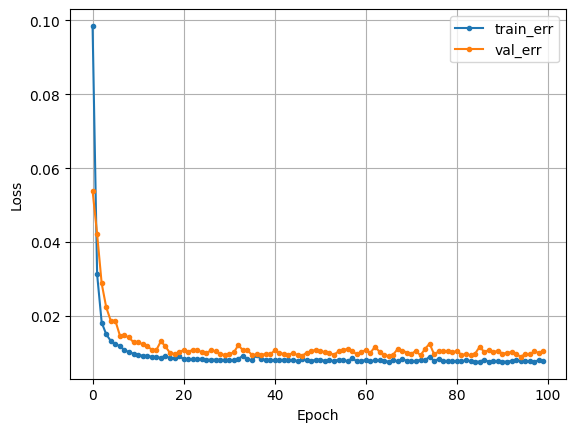

In [23]:
dl_history_plot(hist.history)

In [26]:
y_pred = model_base.predict(x_val)

y_train_real = y_train * (y_max - y_min) + y_min
y_val_real = y_val * (y_max - y_min) + y_min
y_val_pred_real  = y_pred * (y_max - y_min) + y_min

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


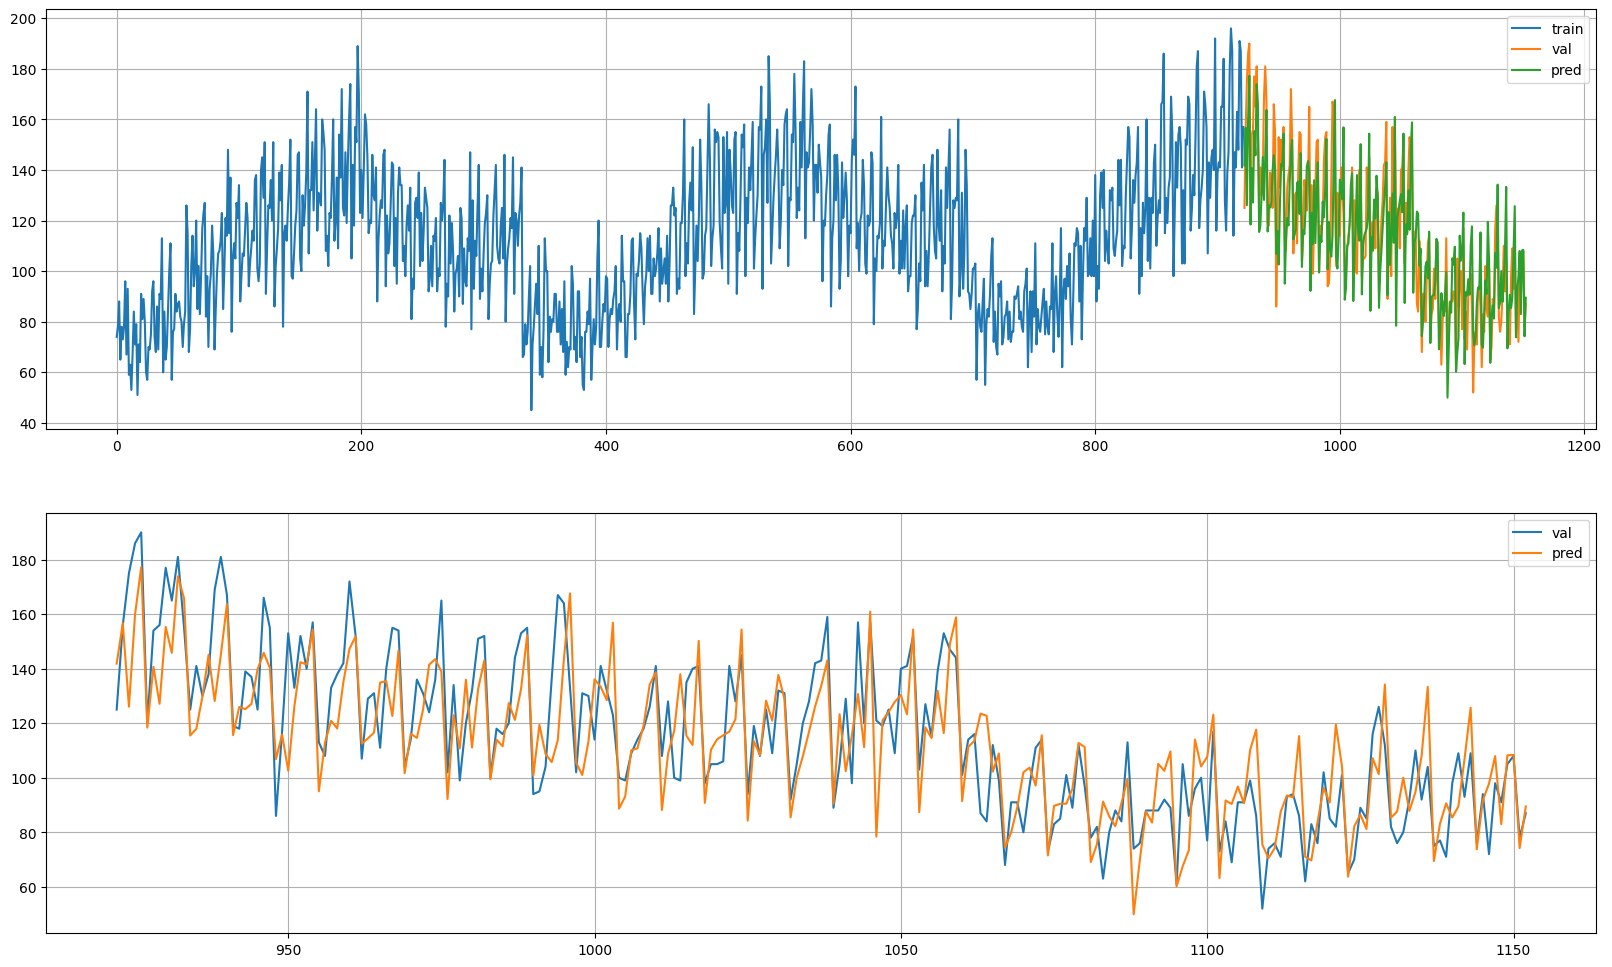

In [27]:
plot_model_result(y_train_real, y_val_real, y_val_pred_real)

In [ ]:
print(y_val_real[:5])
print(y_val_pred_real[:5])

922    125.0
923    156.0
924    175.0
925    186.0
926    190.0
Name: y, dtype: float64
[[129.4111 ]
 [150.69109]
 [125.47637]
 [155.92581]
 [173.34213]]


In [28]:
print('MAE:',mean_absolute_error(y_val_real, y_val_pred_real))
print('R2_Score:',r2_score(y_val_real, y_val_pred_real))

MAE: 12.737942782315342
R2_Score: 0.6652893417309406


# **4.LSTM, CNN 초기 모델**

* **세부 요구사항**
    * 3차원 데이터 구조 만들기
        * timestep 수는 적절한 간격으로 한가지 경우만 지정을 합니다.
    * LSTM, CNN 기반 초기 모델 생성
        * 성능 보다는 코드 틀을 작성하는데 집중합시다.
        * 노드 혹은 필터 수와 크기는 초기값으로 적절하게 지정해 봅시다.

In [29]:
def temporalize(x, y, timesteps):
    output_X = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        output_X.append(x.iloc[i:i+timesteps])
        output_y.append(y.iloc[i+timesteps-1])
    return np.array(output_X), np.array(output_y)

# 시계열 데이터 전처리 2차원 --> 3차원으로 변환
def temporalize_pred(x, y, timesteps):
    nfeature = x.shape[1]
    output_x = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        t = []
        for j in range(timesteps):
            t.append(x[[(i + j)], :])
        output_x.append(t)
        output_y.append(y[i + timesteps - 1])
    return np.array(output_x).reshape(-1,timesteps, nfeature), np.array(output_y)

## **(1) LSTM 초기 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

In [65]:
x = data.drop(target, axis = 1)
y = data.loc[:,target]

scaler_x = MinMaxScaler()
# scaler_y = MinMaxScaler()

# x 스케일링
x_scaled = scaler_x.fit_transform(x)

# y 스케일링
y_max, y_min = y.max(), y.min()
y_scaled = (y - y_min) / (y_max - y_min)
# y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

x, y = temporalize_pred(x_scaled, y_scaled, 7)

In [66]:
from sklearn.model_selection import train_test_split
val_size = 60
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=val_size, shuffle=False)

In [67]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2]))
x_val = x_val.reshape((x_val.shape[0], x_val.shape[1], x_val.shape [2]))

* **모델링**

In [68]:
model = Sequential()
model.add(LSTM (10, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['MeanAbsoluteError'])
history = model.fit(x_train, y_train, epochs= 100, batch_size=32, validation_data=(x_val, y_val)).history

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - MeanAbsoluteError: 0.1380 - loss: 0.0325 - val_MeanAbsoluteError: 0.1068 - val_loss: 0.0229
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - MeanAbsoluteError: 0.0844 - loss: 0.0128 - val_MeanAbsoluteError: 0.1004 - val_loss: 0.0199
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - MeanAbsoluteError: 0.0791 - loss: 0.0118 - val_MeanAbsoluteError: 0.0926 - val_loss: 0.0182
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 0.0705 - loss: 0.0090 - val_MeanAbsoluteError: 0.0876 - val_loss: 0.0171
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - MeanAbsoluteError: 0.0652 - loss: 0.0079 - val_MeanAbsoluteError: 0.0856 - val_loss: 0.0165
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - MeanAbsoluteError: 0.0603 - loss: 0.0070 - val_MeanAbsoluteError: 0.0836 - val_loss: 0.0162
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 0.0601 - loss: 0.0073 - val_MeanAbsoluteError: 0.0822 - v

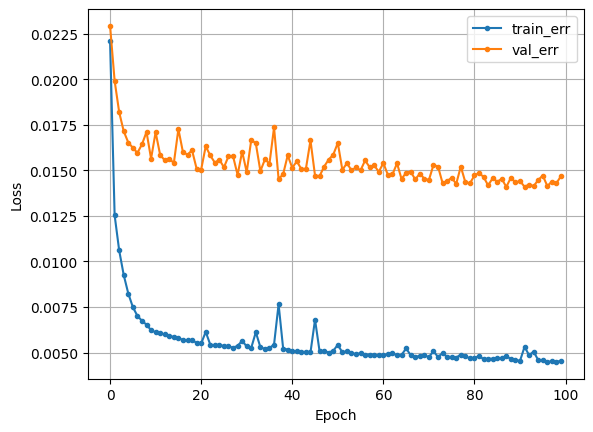

In [69]:
dl_history_plot(history)

In [72]:
y_pred = model.predict(x_val)

y_train_real = y_train * (y_max - y_min) + y_min
y_val_real = y_val * (y_max - y_min) + y_min
y_val_pred_real  = y_pred * (y_max - y_min) + y_min

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [73]:
print(f'RMSE: {root_mean_squared_error(y_val_real, y_val_pred_real)}')
print(f'MAE: {mean_absolute_error(y_val_real, y_val_pred_real)}')
print(f'MAPE: {mean_absolute_percentage_error(y_val_real, y_val_pred_real)}')
print(f'R2 Score: {r2_score(y_val_real, y_val_pred_real)}')

RMSE: 3079.5078585952124
MAE: 1895.533837890625
MAPE: 1.1011721835370426e+18
R2 Score: 0.39836637289332355


### **2) 상품 : 12 - Milk**

* **데이터 준비**

In [83]:
# X와 y를 pandas DataFrame 및 Series 형태로 유지
X_df = X_processed
y_df = pd.DataFrame(y_scaled, columns=['Target'])

# 시계열 데이터로 변환
timesteps = 7  # 예시로 7일간의 데이터를 사용
X_seq, y_seq = temporalize(X_df, y_df['Target'], timesteps)

In [84]:
# 데이터 분할 (최근 60일을 검증 셋으로 사용)
train_size = len(X_seq) - 60
X_train, X_val = X_seq[:train_size], X_seq[train_size:]
y_train, y_val = y_seq[:train_size], y_seq[train_size:]

In [85]:
# 데이터 타입 변환 (float32)
X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)
y_train = y_train.astype(np.float32)
y_val = y_val.astype(np.float32)

* **모델링**

In [90]:
# LSTM 모델 구성
model_LSTM_12 = Sequential()
model_LSTM_12.add(LSTM(50, input_shape=(timesteps, X_train.shape[2])))  # LSTM 유닛 수는 50
model_LSTM_12.add(Dense(1))  # 출력 레이어

# 모델 컴파일
model_LSTM_12.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# 모델 학습
history = model_LSTM_12.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_val, y_val), verbose=1)


Epoch 1/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0369 - val_loss: 0.0073
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0047 - val_loss: 0.0070
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0050 - val_loss: 0.0070
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0041 - val_loss: 0.0076
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0030 - val_loss: 0.0066
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0030 - val_loss: 0.0070
Epoch 7/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0043 - val_loss: 0.0066
Epoch 8/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0040 - val_loss: 0.0066
Epoch 9/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0042 - val_loss: 0.0063
Epoch 10/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0036 - val_loss: 0.0060
Epoch 11/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0054 - val_loss: 0.0066
Epoch 12/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0052 - val_lo

In [91]:
# 검증 성능 평가
# 예측
y_pred_scaled = model_LSTM_12.predict(X_val)

# 예측 값을 원래 스케일로 되돌리기
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_val_original = y_scaler.inverse_transform(y_val.reshape(-1, 1))

# 평가 지표 계산
rmse = sqrt(mean_squared_error(y_val_original, y_pred))
mae = mean_absolute_error(y_val_original, y_pred)
mape = np.mean(np.abs((y_val_original - y_pred.flatten()) / y_val_original)) * 100  # MAPE 계산
r2 = r2_score(y_val_original, y_pred)

# 결과 출력
print("RMSE:", rmse)
print("MAE:", mae)
print("MAPE:", mape)
print("R2 Score:", r2)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
RMSE: 3038.4864653310538
MAE: 1752.8574
MAPE: inf
R2 Score: 0.24871528148651123


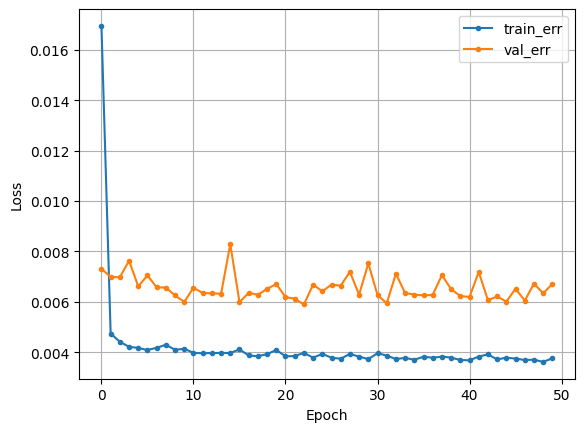

In [92]:
dl_history_plot(history.history)

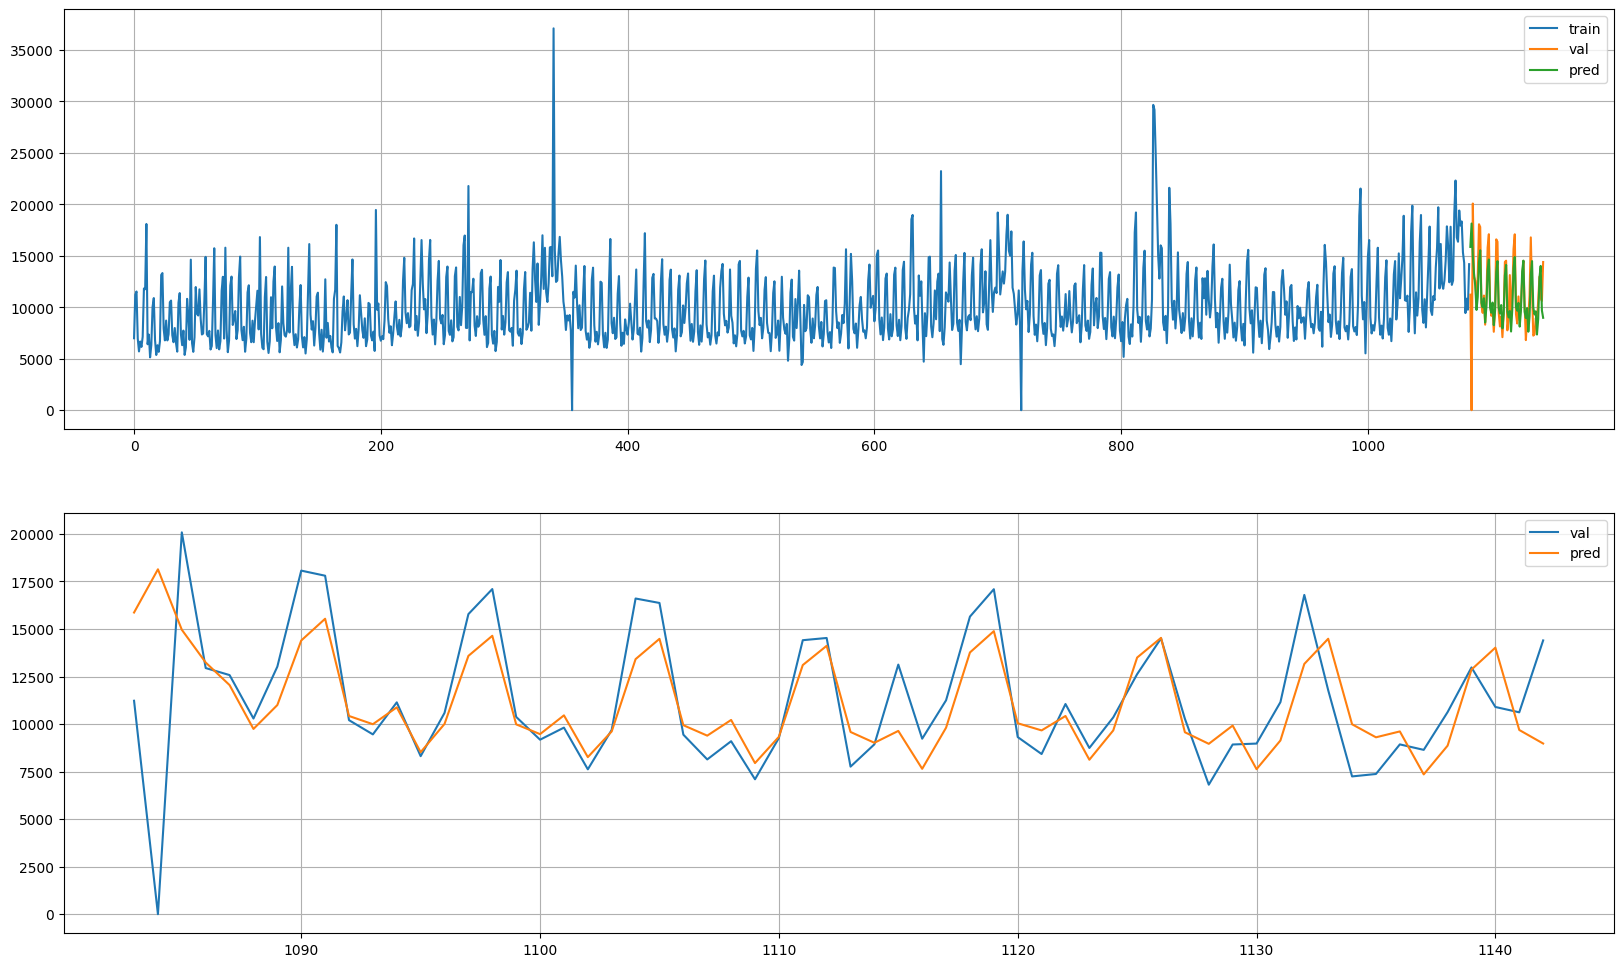

In [93]:
# y_train 및 y_val의 원래 스케일로 변환 (역스케일링)
y_train_original = y_scaler.inverse_transform(y_train.reshape(-1, 1)).reshape(-1,)
y_val_original = y_scaler.inverse_transform(y_val.reshape(-1, 1)).reshape(-1,)
y_pred_original = y_scaler.inverse_transform(y_pred_scaled).reshape(-1,)  # 예측 결과의 역스케일링

# 시각화 함수 호출
plot_model_result(y_train_original, y_val_original, y_pred_original)

### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

In [30]:
#sales_44.drop(columns = ['Date', 'Store_ID', 'Product_ID'], inplace = True)
len(sales_44)

1153

In [31]:
x_s[:2], y_s[:2]

(array([[0.0397351 , 0.84332192, 0.32689349, 0.35951628, 0.47016919,
         0.34871851, 0.        , 1.        , 0.        , 0.        ,
         0.        , 0.        ],
        [0.20529801, 0.84332192, 0.32689349, 0.35951628, 0.47016919,
         0.34871851, 0.        , 0.        , 1.        , 0.        ,
         0.        , 0.        ]]),
 0    0.192053
 1    0.218543
 Name: y, dtype: float64)

In [33]:
bundle_size = 12
x_L, y_L = temporalize_pred(x_s, y_s, bundle_size)
x_L.shape, y_L.shape

((1142, 12, 12), (1142,))

In [34]:
x_train, x_val, y_train, y_val = train_test_split(x_L, y_L, test_size= 60, shuffle = False)

In [35]:
x_train.shape, y_train.shape

((1082, 12, 12), (1082,))

* **모델링**

In [36]:
nfeatures = x_train.shape[2]

In [37]:
clear_session()

LSTM_proto = Sequential([Input(shape = (bundle_size, nfeatures)),
                     LSTM(24, return_sequences=False),
                     Dense(1)])

LSTM_proto.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 24)                  │           3,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              25 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,577 (13.97 KB)

 Trainable params: 3,577 (13.97 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
LSTM_proto.compile(optimizer='adam', loss='mse')

In [39]:
hist2 = LSTM_proto.fit(x_train, y_train, validation_split=.2, epochs=100)

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.1061 - val_loss: 0.0739
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0390 - val_loss: 0.0441
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0236 - val_loss: 0.0284
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0143 - val_loss: 0.0162
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0091 - val_loss: 0.0115
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0088 - val_loss: 0.0109
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0076 - val_loss: 0.0118
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0075 - val_loss: 0.0118
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0084 - val_loss: 0.0099
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0070 - val_loss: 0.0096
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0068 - val_loss: 0.0093
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0

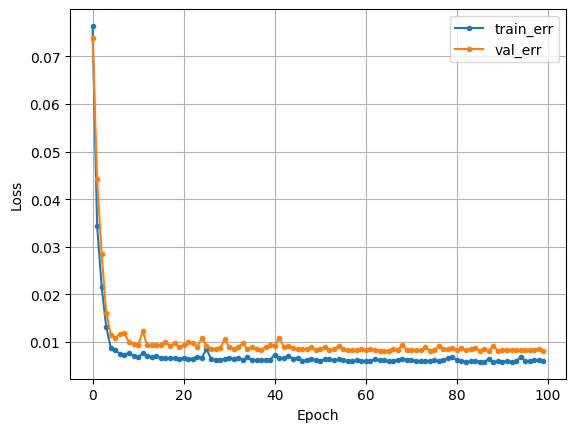

In [40]:
dl_history_plot(hist2.history)

In [41]:
y_pred = LSTM_proto.predict(x_val)

y_train_real = y_train * (y_max - y_min) + y_min
y_val_real = y_val * (y_max - y_min) + y_min
y_val_pred_real  = y_pred * (y_max - y_min) + y_min

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


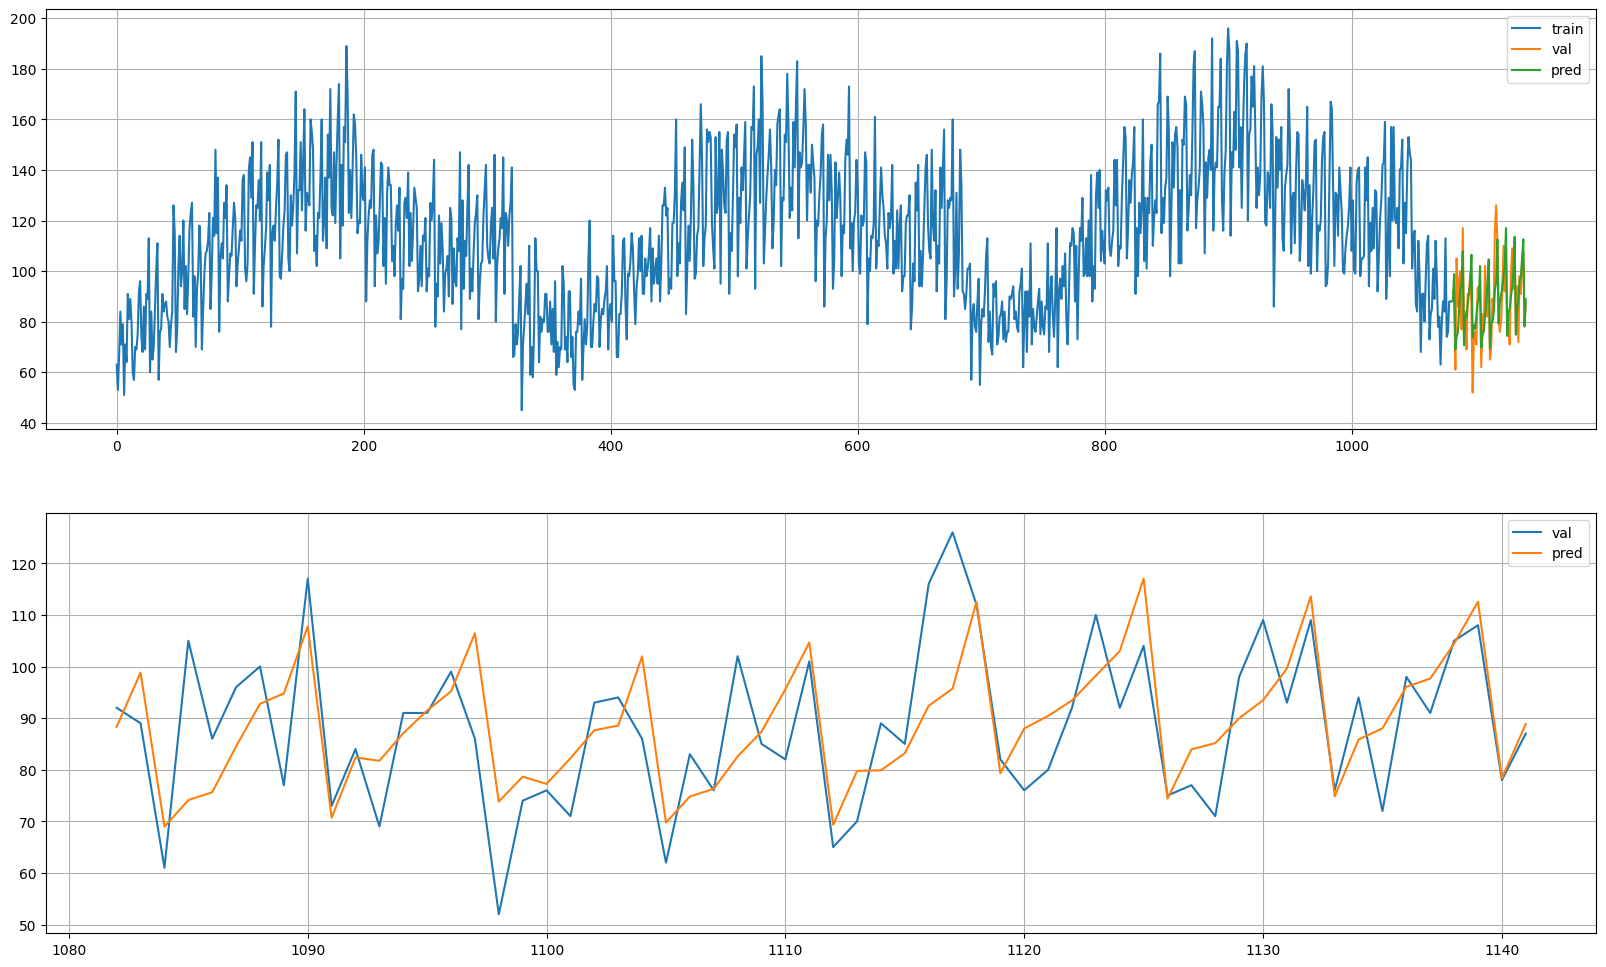

In [42]:
plot_model_result(y_train_real, y_val_real, y_val_pred_real)

In [ ]:
for idx in range(10):
  print(y_val_real[idx], y_val_pred_real[idx])

92.0 [93.64848]
89.0 [105.69658]
61.0 [74.775406]
105.0 [79.70189]
86.0 [76.81847]
96.0 [84.24373]
100.0 [94.869995]
77.0 [98.83174]
117.0 [113.88306]
73.0 [76.06524]


In [43]:
print('MAE:',mean_absolute_error(y_val_real, y_val_pred_real))
print('R2_Score:',r2_score(y_val_real, y_val_pred_real))

MAE: 8.57235959370931
R2_Score: 0.45878591823882575


## **(2) CNN 초기 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

* **모델링**

### **2) 상품 : 12 - Milk**

* **데이터 준비**

* **모델링**

### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

* **모델링**

# **5.데이터 저장**

* **세부 요구사항**
    * 상품코드별 데이터셋을 저장하시오.
    * joblib.dump를 이용하시오.
    * 저장할 파일의 확장자는 보통 .pkl 입니다.

In [ ]:
joblib.dump(sales_44, 'df_안영민.pkl')

['df_안영민.pkl']